In [94]:
import sys
sys.path.append("/home/gant/Documents/tpcanalysis/python_comp/src")
from openImage import openImage
import matplotlib.pyplot as plt
import numpy as np

from skimage.transform import hough_line, hough_line_peaks, probabilistic_hough_line, FundamentalMatrixTransform
from skimage.feature import canny
from skimage.draw import line
from skimage.color import rgb2gray
from skimage.color import label2rgb
from skimage.segmentation import slic
from skimage.segmentation import felzenszwalb
from skimage.segmentation import mark_boundaries
import skimage.filters
from skimage.measure import LineModelND, ransac
from sklearn.linear_model import LinearRegression
from skimage.morphology import skeletonize

from matplotlib import cm

In [95]:
test_image = openImage("/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages/CoBo_2018-06-20T10-51-39.459_0000/25_v.png")
test_image.readImage()
#test_image.trimImage()
#test_image.m_data = np.where(test_image.m_data > 0.99, 0, test_image.m_data)

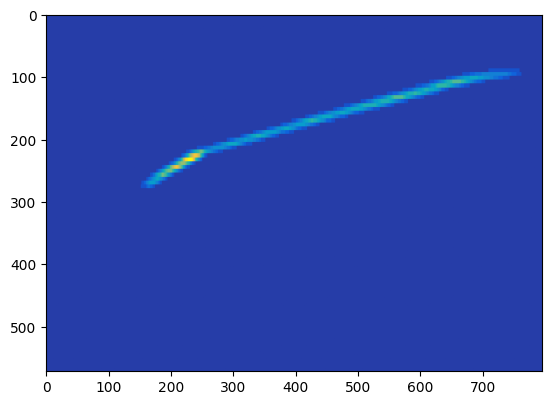

In [96]:
#test MatPlotLib
test_image.viewImage()

In [97]:
#black and white

test_image.m_data = rgb2gray(test_image.m_data)
test_image.m_data = np.where(test_image.m_data < 0.3, 0, test_image.m_data)
test_image.m_data = np.where(test_image.m_data >= 0.3, 1, test_image.m_data)
#test_image.m_data = skimage.filters.gaussian(test_image.m_data, sigma=(3.0, 3.0), truncate=3.5)


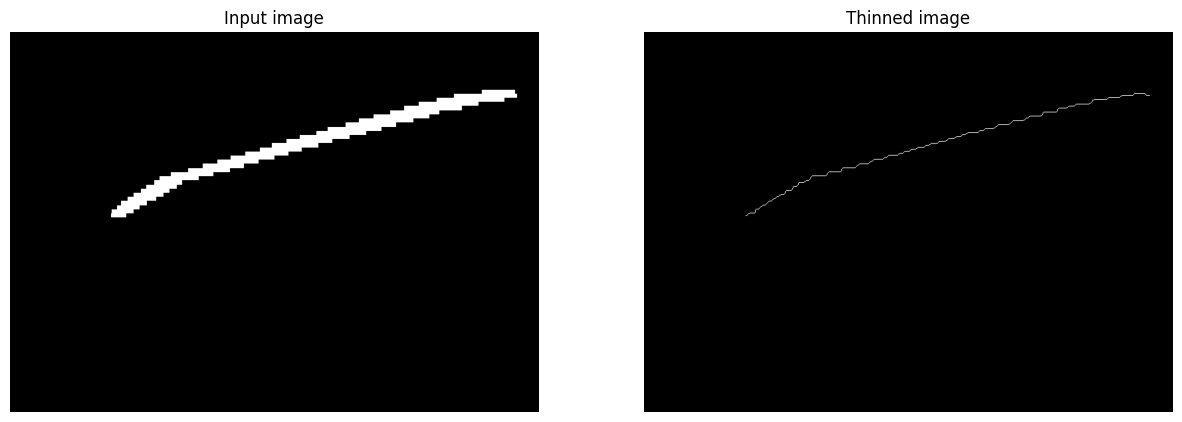

In [98]:
#thin lines

def processPixelSeries(series):

    middle_pixel = len(series) // 2
    series[middle_pixel:] = 0  # Set the right half to black
    half_width = len(series) // 2
    left_index = middle_pixel - half_width
    right_index = middle_pixel + half_width + 1
    series[right_index:] = 0  # Set the right half to black
    series[:left_index] = 0  # Set the left half to black

    return series

def processRow(row):

    # Find the indices where the consecutive series of 1s start and end
    starts = np.where(np.diff(np.concatenate(([0], row, [0]))) == 1)[0]
    ends = np.where(np.diff(np.concatenate(([0], row, [0]))) == -1)[0]

    # Iterate over the series and call the processPixelSeries function
    for start, end in zip(starts, ends):
        series = row[start:end]
        if len(series) > 5:
            row[start:end] = processPixelSeries(series)


        
    return row

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(test_image.m_data, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

""" for row in test_image.m_data:
    processRow(row) """
test_image.m_data = skeletonize(test_image.m_data)

ax[1].imshow(test_image.m_data, cmap=cm.gray)
ax[1].set_title('Thinned image')
ax[1].set_axis_off()



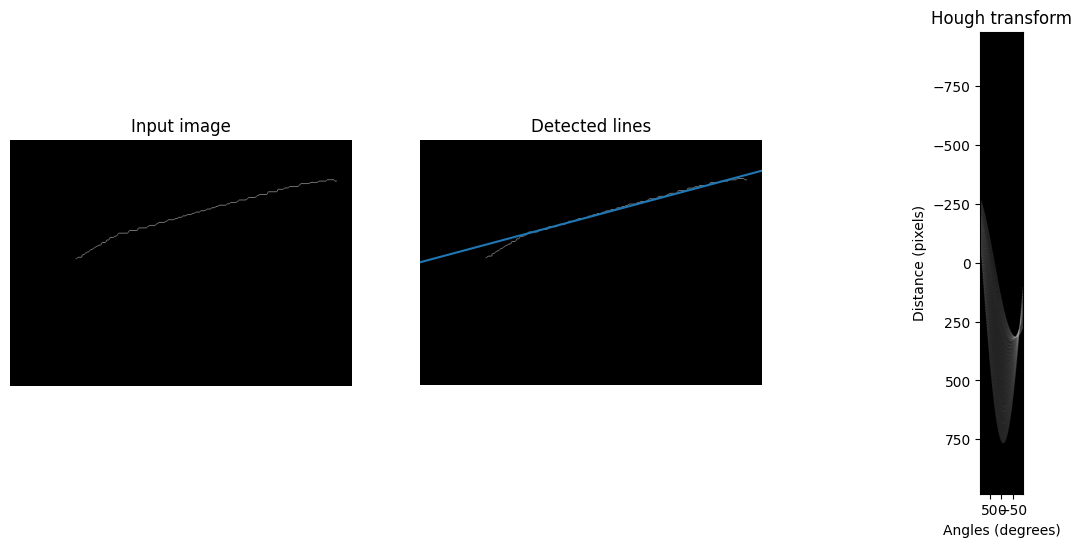

In [99]:
#hough transform

""" tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 180, endpoint=False)
h, theta, d = hough_line(test_image.m_data, theta=tested_angles) """
h, theta, d = hough_line(test_image.m_data)

fig, axes = plt.subplots(1, 3, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(test_image.m_data, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(test_image.m_data, cmap=cm.gray)
ax[1].set_ylim((test_image.m_data.shape[0], 0))
ax[1].set_axis_off()
ax[1].set_title('Detected lines')



ax[2].imshow(np.log(1 + h), extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
           d[-1], d[0]], cmap=cm.gray, aspect=1/1.5)
ax[2].set_title('Hough transform')
ax[2].set_xlabel('Angles (degrees)')
ax[2].set_ylabel('Distance (pixels)')
ax[2].axis('image')



for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[1].axline((x0, y0), slope=np.tan(angle + np.pi/2))

""" origin = np.array((0, test_image.m_data.shape[0]))


for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    y0, y1 = (dist - origin * np.cos(angle)) / np.sin(angle)
    ax[1].plot(origin, (y0, y1), '-r') """




plt.show()

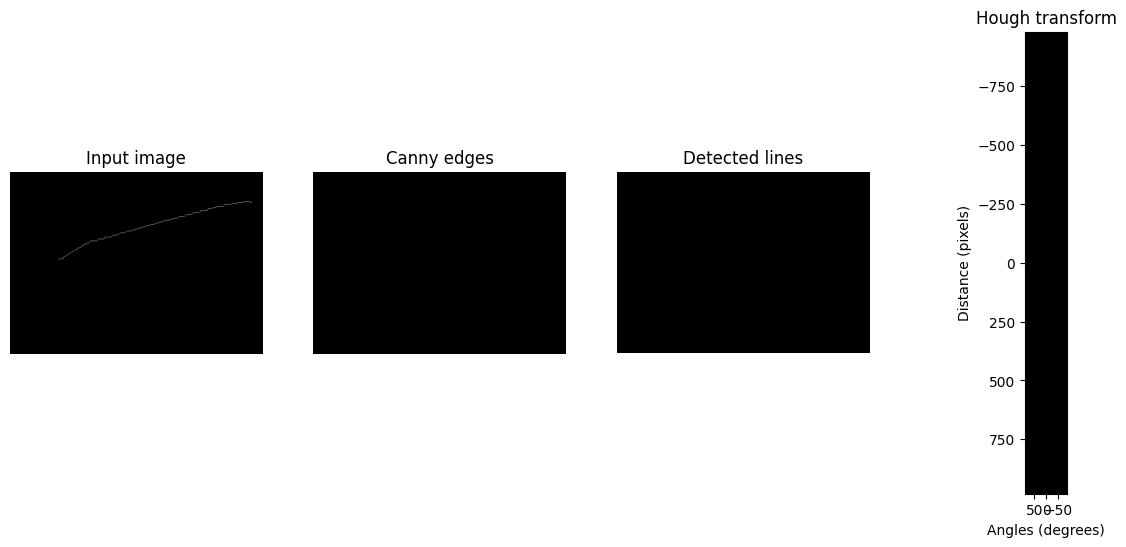

In [100]:


edges = skimage.filters.gaussian(test_image.m_data, sigma=(3.0, 3.0), truncate=3.5)
edges = canny(edges, sigma = 2.5)


#dges = canny(test_image.m_data, sigma = 2.5)

h, theta, d = hough_line(edges)

fig, axes = plt.subplots(1, 4, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(test_image.m_data, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')
ax[1].set_axis_off()


ax[2].set_ylim((edges.shape[0], 0))
ax[2].set_axis_off()
ax[2].set_title('Detected lines')



ax[3].imshow(np.log(1 + h), extent=[np.rad2deg(theta[-1]), np.rad2deg(theta[0]),
           d[-1], d[0]], cmap=cm.gray, aspect=1/1.5)
ax[3].set_title('Hough transform')
ax[3].set_xlabel('Angles (degrees)')
ax[3].set_ylabel('Distance (pixels)')
ax[3].axis('image')


line_eq=[]

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax[2].axline((x0, y0), slope=np.tan(angle + np.pi/2))

    slope = np.tan(angle)
    intercept = dist / np.sin(angle)

    line_eq.append((slope, intercept))

ax[2].imshow(edges, cmap=cm.gray)


for slope, intercept in line_eq:
    print(f"Line is: y = {slope} * x + {intercept}\n")


plt.show()

Equation: y = -0.29143265805335616*x+298.63247412834596

Stopped at iteration number 1


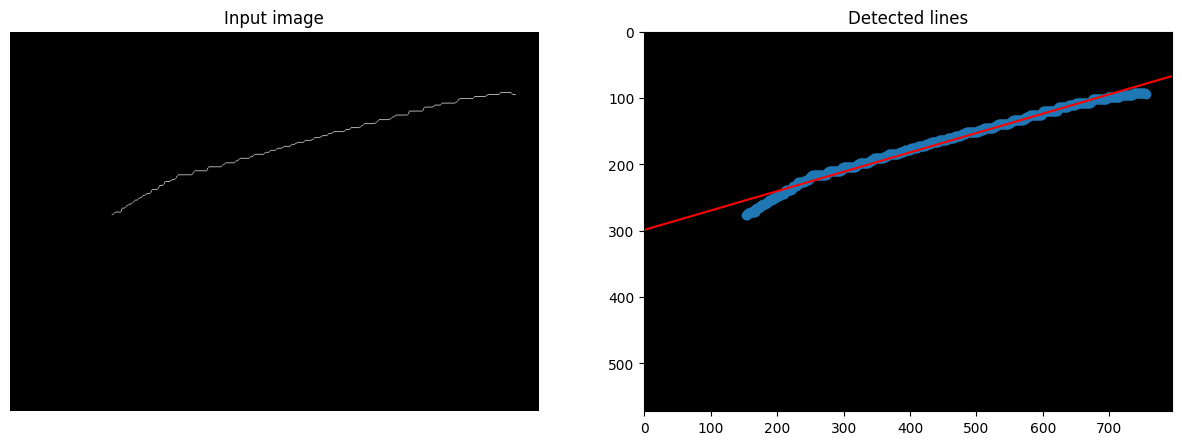

In [101]:
#ransac



fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(test_image.m_data, cmap=cm.gray)
ax[0].set_title('Input image')
ax[0].set_axis_off()

ax[1].imshow(test_image.m_data, cmap=cm.gray)
ax[1].set_ylim((test_image.m_data.shape[0], 0))
#ax[1].set_axis_off()
ax[1].set_title('Detected lines')


lines_eq=[]

ransac_data = test_image.m_data

points = np.argwhere(ransac_data == 1)[:, ::-1]

for i in range(10):

    if(len(points) < 11):
        print(f"\nStopped at iteration number {i}")
        break

    model, inliers = ransac(points, LineModelND, min_samples=10, residual_threshold=15, random_state=0)

    outliers = inliers == False

    ax[1].scatter(points[inliers][:, 0], points[inliers][:, 1]) 

    slope = model.params[1][1] / \
        model.params[1][0]
    intercept = model.params[0][1] - \
        slope * model.params[0][0]


    print(f"Equation: y = {slope}*x+{intercept}")
    #print(f"Line from {model.params[0][0]}, {model.params[0][1]} to {model.params[1][0]}, {model.params[1][1]}")


    x = np.arange(0, test_image.m_data.shape[1])
    #x = np.arange(points[inliers][:, 0].min(), points[inliers][:, 0].max())
    y = slope * x + intercept


    ax[1].plot(x, y, label="fitted line", color='red')

    points = points[outliers]

    lines_eq.append([slope, intercept])


intersections=[]

for i, (slope1, intercept1) in enumerate(lines_eq):
    for slope2, intercept2 in lines_eq[i + 1:]:
        if slope1 != slope2:  # Lines are not parallel
            x = (intercept2 - intercept1) / (slope1 - slope2)
            y = slope1 * x + intercept1
            if(x>0 and x<800 and y>0 and y<600):
                intersections.append((x, y))

for x, y in intersections:
    print(f"Point is ({x}, {y})")







Number of lines: 0


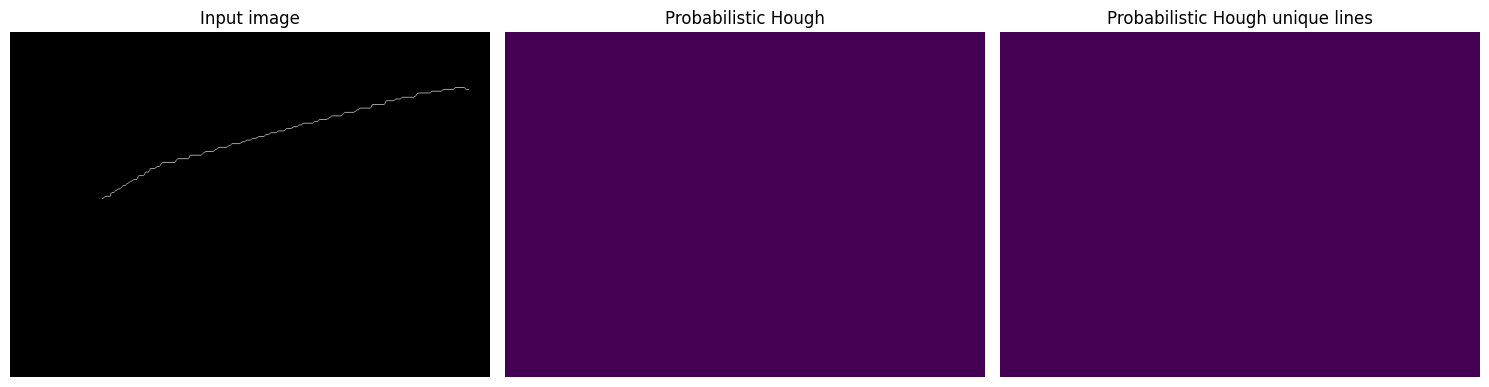

In [102]:
#probabilistic hough transform


lines = probabilistic_hough_line(test_image.m_data, threshold=10, line_length=50,
                                 line_gap=3, seed = 0)

# Generating figure 2
fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(test_image.m_data, cmap=cm.gray)
ax[0].set_title('Input image')



ax[1].imshow(test_image.m_data * 0)


def get_slope_intercept(p0, p1):
    if p1[0] - p0[0] != 0:
        slope = (p1[1] - p0[1]) / (p1[0] - p0[0])
    else:
        slope = float('inf')

    intercept = p0[1] - slope * p0[0]

    return slope, intercept




line_s_i_format=[]

for line in lines:
    p0, p1 = line
    ax[1].plot((p0[0], p1[0]), (p0[1], p1[1]))

    line_s_i_format.append(get_slope_intercept(p0, p1))

ax[1].set_xlim((0, test_image.m_data.shape[1]))
ax[1].set_ylim((test_image.m_data.shape[0], 0))
ax[1].set_title('Probabilistic Hough')


print(f"Number of lines: {len(line_s_i_format)}")

""" for slope, intercept in line_s_i_format:
    print(f"Slope is {slope}\nIntercept is {intercept}\n\n") """

unique_lines=[]
slopes_th=0.1

for slope, intercept in line_s_i_format:
    if unique_lines == False:
        unique_lines.append((slope, intercept))
        print(f"Slope is {slope}\n")
    else:
        if all(abs(slope - unique_slope) > slopes_th for unique_slope, _ in unique_lines):
            unique_lines.append((slope, intercept))
            print(f"Slope is {slope}\n")



ax[2].imshow(test_image.m_data * 0)
ax[2].set_xlim((0, test_image.m_data.shape[1]))
ax[2].set_ylim((test_image.m_data.shape[0], 0))
ax[2].set_title('Probabilistic Hough unique lines')

x = np.linspace(0, test_image.m_data.shape[1], 100)

for slope, intercept in unique_lines:
    y = slope * x + intercept
    ax[2].plot(x, y)


for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

Number of lines: 0


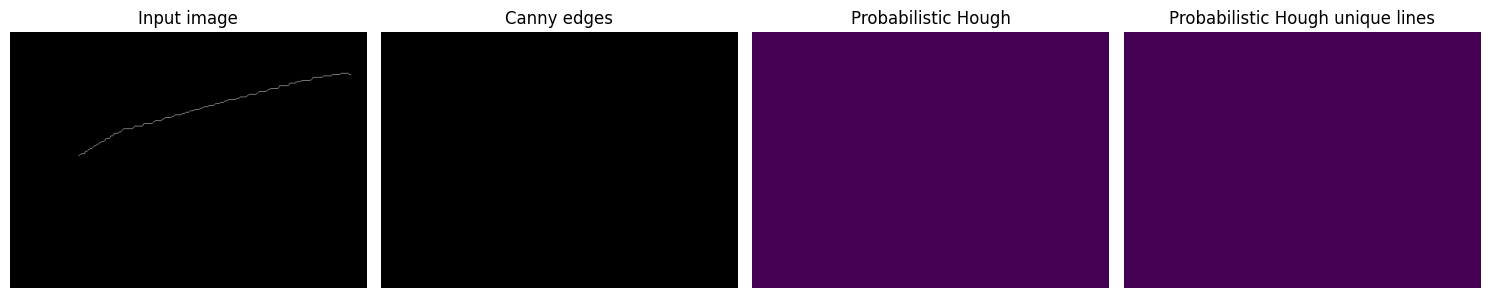

In [103]:
#canny edges and probabilistic hough transform

#edges = canny(test_image.m_data, sigma = 2.5)
edges = skimage.filters.gaussian(test_image.m_data, sigma=(3.0, 3.0), truncate=3.5)
edges = canny(edges, sigma = 2.5) 


lines = probabilistic_hough_line(edges, threshold=10, line_length=1,
                                 line_gap=6, seed = 0)

# Generating figure 2
fig, axes = plt.subplots(1, 4, figsize=(15, 5), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(test_image.m_data, cmap=cm.gray)
ax[0].set_title('Input image')

ax[1].imshow(edges, cmap=cm.gray)
ax[1].set_title('Canny edges')
ax[1].set_axis_off()

ax[2].imshow(edges * 0)


def get_slope_intercept(p0, p1):
    if p1[0] - p0[0] != 0:
        slope = (p1[1] - p0[1]) / (p1[0] - p0[0])
    else:
        slope = float('inf')

    intercept = p0[1] - slope * p0[0]

    return slope, intercept




line_s_i_format=[]

for line in lines:
    p0, p1 = line
    ax[2].plot((p0[0], p1[0]), (p0[1], p1[1]))

    line_s_i_format.append(get_slope_intercept(p0, p1))

ax[2].set_xlim((0, test_image.m_data.shape[1]))
ax[2].set_ylim((test_image.m_data.shape[0], 0))
ax[2].set_title('Probabilistic Hough')


print(f"Number of lines: {len(line_s_i_format)}")

""" for slope, intercept in line_s_i_format:
    print(f"Slope is {slope}\nIntercept is {intercept}\n\n") """

unique_lines=[]
slopes_th=0.1

for slope, intercept in line_s_i_format:
    if unique_lines == False:
        unique_lines.append((slope, intercept))
        print(f"Slope is {slope}\n")
    else:
        if all(abs(slope - unique_slope) > slopes_th for unique_slope, _ in unique_lines):
            unique_lines.append((slope, intercept))
            print(f"Slope is {slope}\n")



ax[3].imshow(edges * 0)
ax[3].set_xlim((0, test_image.m_data.shape[1]))
ax[3].set_ylim((test_image.m_data.shape[0], 0))
ax[3].set_title('Probabilistic Hough unique lines')

x = np.linspace(0, test_image.m_data.shape[1], 100)

for slope, intercept in unique_lines:
    y = slope * x + intercept
    ax[3].plot(x, y)


for a in ax:
    a.set_axis_off()

plt.tight_layout()
plt.show()

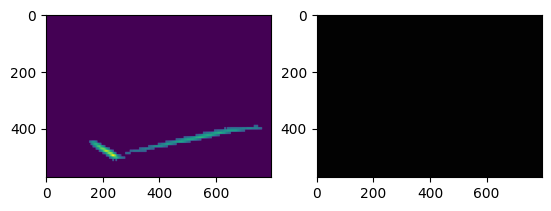

In [104]:
#Simple linear iterative clustering

ul_image = openImage("/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages/CoBo_2018-06-20T10-51-39.459_0000/25_u.png")
ul_image.readImage()



#ul_image.trimImage()
ul_image.m_data = rgb2gray(ul_image.m_data)
ul_image.m_data = np.where(ul_image.m_data < 0.3, 0, ul_image.m_data)

plt.subplot(1,2,1)
 
# Plotting the original image
plt.imshow(ul_image.m_data)



ul_segments = slic(ul_image.m_data,
                          n_segments=3,
                          compactness=10)

plt.subplot(1,2,2)
 
# Converts a label image into
# an RGB color image for visualizing
# the labeled regions.
plt.imshow(label2rgb(ul_segments,
                     ul_image.m_data,
                     kind = 'avg'))

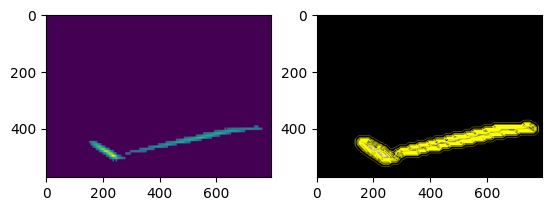

In [105]:
#elzenszwalb


uf_image = openImage("/media/gant/Expansion/tpc_root_raw/DATA_ROOT/cleanimages/CoBo_2018-06-20T10-51-39.459_0000/25_u.png")
uf_image.readImage()


uf_image.trimImage()
uf_image.m_data = rgb2gray(uf_image.m_data)
uf_image.m_data = np.where(uf_image.m_data < 0.3, 0, uf_image.m_data)






uf_segments = felzenszwalb(uf_image.m_data,
                                  scale = 5,
                                  sigma=5,
                                  min_size=20)


 
# Plotting the original image
plt.subplot(1,2,1)
plt.imshow(uf_image.m_data)
 
# Marking the boundaries of
# Felzenszwalb's segmentations
plt.subplot(1,2,2)
plt.imshow(mark_boundaries(uf_image.m_data,
                           uf_segments))


In [106]:
#cu xyz
""" xyz_image = openImage("./datafiles/test_xyz.png")
xyz_image.readImage()


#black and white

xyz_image.m_data = rgb2gray(xyz_image.m_data)
xyz_image.m_data[:, 0] = 0.99
xyz_image.m_data = 1 - xyz_image.m_data
xyz_image.m_data = np.where(xyz_image.m_data < 0.5, 0, xyz_image.m_data) """

' xyz_image = openImage("./datafiles/test_xyz.png")\nxyz_image.readImage()\n\n\n#black and white\n\nxyz_image.m_data = rgb2gray(xyz_image.m_data)\nxyz_image.m_data[:, 0] = 0.99\nxyz_image.m_data = 1 - xyz_image.m_data\nxyz_image.m_data = np.where(xyz_image.m_data < 0.5, 0, xyz_image.m_data) '

In [107]:
#hough transform cu xyz
""" 
tested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)
#h, theta, d = hough_line(test_image.m_data, theta=tested_angles)
h, theta, d = hough_line(xyz_image.m_data)

fig_xyz, axes_xyz = plt.subplots(1, 2, figsize=(15, 6))
ax_xyz = axes_xyz.ravel()

ax_xyz[0].imshow(xyz_image.m_data, cmap=cm.gray)
ax_xyz[0].set_title('Input image')
ax_xyz[0].set_axis_off()

ax_xyz[1].imshow(xyz_image.m_data, cmap=cm.gray)
ax_xyz[1].set_ylim((xyz_image.m_data.shape[0], 0))
ax_xyz[1].set_axis_off()
ax_xyz[1].set_title('Detected lines')

for _, angle, dist in zip(*hough_line_peaks(h, theta, d)):
    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])
    ax_xyz[1].axline((x0, y0), slope=np.tan(angle + np.pi/2))



plt.show() """

" \ntested_angles = np.linspace(-np.pi / 2, np.pi / 2, 360, endpoint=False)\n#h, theta, d = hough_line(test_image.m_data, theta=tested_angles)\nh, theta, d = hough_line(xyz_image.m_data)\n\nfig_xyz, axes_xyz = plt.subplots(1, 2, figsize=(15, 6))\nax_xyz = axes_xyz.ravel()\n\nax_xyz[0].imshow(xyz_image.m_data, cmap=cm.gray)\nax_xyz[0].set_title('Input image')\nax_xyz[0].set_axis_off()\n\nax_xyz[1].imshow(xyz_image.m_data, cmap=cm.gray)\nax_xyz[1].set_ylim((xyz_image.m_data.shape[0], 0))\nax_xyz[1].set_axis_off()\nax_xyz[1].set_title('Detected lines')\n\nfor _, angle, dist in zip(*hough_line_peaks(h, theta, d)):\n    (x0, y0) = dist * np.array([np.cos(angle), np.sin(angle)])\n    ax_xyz[1].axline((x0, y0), slope=np.tan(angle + np.pi/2))\n\n\n\nplt.show() "